In [2]:
import numpy as np
np.random.seed(1337)
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.models import Model
from keras.layers import Input, Embedding, Dot, Add, Flatten
from keras.regularizers import l2
from keras.optimizers import SGD, Adam
from keras.models import load_model

Using TensorFlow backend.


In [34]:
df = pd.read_csv('edited_ratings_subset_larger.csv')
df = pd.DataFrame(df)
df = shuffle(df)

In [35]:
N = df.userId.max() + 1
M = df.movie_idx.max() + 1
(N,M)

(50, 200)

In [36]:
cutoff = int(0.8*len(df))
ratings_train = df.iloc[:cutoff]
ratings_test = df.iloc[cutoff:]

In [3]:
means = df.groupby(['movie_idx'],as_index = False).mean().sort_values(by = 'movie_idx')
means[means.movie_idx.isin([165,106])]


,movie_idx,Unnamed: 0,userId,movieId,rating
106,106,57350.322581,20.419355,1258.0,4.032258
165,165,60694.125000,24.750000,1259.0,3.791667


In [4]:
n_ratings = df.groupby(['movie_idx'],as_index = False).count()
n_ratings[n_ratings.movie_idx.isin([165,106])]

,movie_idx,Unnamed: 0,userId,movieId,rating
106,106,31,31,31,31
165,165,24,24,24,24


In [24]:
K = 6
mu = ratings_train.rating.mean()
epochs=25
reg = 0.05
u = Input(shape = (1,))
m = Input(shape = (1,))
u_embedding = Embedding(N,K,embeddings_regularizer = l2(reg))(u)
m_embedding = Embedding(M,K,embeddings_regularizer = l2(reg))(m)

u_bias = Embedding(N,1,embeddings_regularizer = l2(reg))(u)
m_bias = Embedding(M,1,embeddings_regularizer = l2(reg))(m)
x = Dot(axes = 2)([u_embedding,m_embedding])

x = Add()([x, u_bias, m_bias])
x = Flatten()(x)

model = Model(inputs = [u, m], outputs = x)

In [25]:
#Orig:lr-0.007,epoch-25,batchsize-64
model.compile(
loss = 'mse',
#optimizer = SGD(lr = 0.007, momentum = 0.9),
optimizer = 'adam',
metrics = ['mse']
)

In [26]:
r = model.fit(
    x = [ratings_train.userId.values, ratings_train.movie_idx.values],
    y = ratings_train.rating.values - mu,
    epochs = epochs,
    batch_size = 64,
    validation_data = (
        [ratings_test.userId.values, ratings_test.movie_idx.values],
        ratings_test.rating.values - mu
    ),
    shuffle = False
)

Train on 5188 samples, validate on 1298 samples
Epoch 1/25
5188/5188 [==============================] - 1s 128us/step - loss: 0.7770 - mean_squared_error: 0.7606 - val_loss: 0.7346 - val_mean_squared_error: 0.7296
Epoch 2/25
5188/5188 [==============================] - 0s 42us/step - loss: 0.7524 - mean_squared_error: 0.7463 - val_loss: 0.7304 - val_mean_squared_error: 0.7227
Epoch 3/25
5188/5188 [==============================] - 0s 41us/step - loss: 0.7455 - mean_squared_error: 0.7365 - val_loss: 0.7295 - val_mean_squared_error: 0.7186
Epoch 4/25
5188/5188 [==============================] - 0s 42us/step - loss: 0.7413 - mean_squared_error: 0.7294 - val_loss: 0.7296 - val_mean_squared_error: 0.7161
Epoch 5/25
5188/5188 [==============================] - 0s 44us/step - loss: 0.7383 - mean_squared_error: 0.7241 - val_loss: 0.7302 - val_mean_squared_error: 0.7146
Epoch 6/25
5188/5188 [==============================] - 0s 48us/step - loss: 0.7361 - mean_squared_error: 0.7199 - val_loss: 0

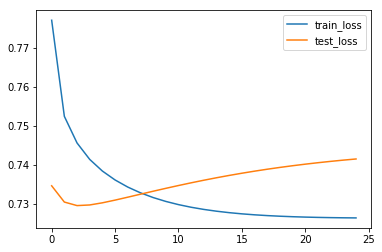

In [27]:
plt.plot(r.history['loss'],label = "train_loss")
plt.plot(r.history['val_loss'],label = "test_loss")
plt.legend()
plt.show()

In [17]:
model.save('martrix_factorization.h5')

In [34]:
from keras.models import load_model

In [35]:
new_model = load_model('martrix_factorization_bkp.h5')

In [5]:
# #mu = ratings_train.rating.mean()
# #new_model.summary()
# weights = new_model.get_weights()
# P = weights[0]
# Q = weights[1]
# B = weights[2]
# C = weights[3]
# new_model.get_summary


In [6]:
#IICF
def IICF_common_ratings(a,b,df1):
    movie_a = df1[df1.userId.isin(np.array(range(50)))][df1.movie_idx==a]
    movie_b = df1[df1.userId.isin(np.array(range(50)))][df1.movie_idx==b]
    movie_a_ids = movie_a.userId.values
    movie_b_ids = movie_b.userId.values
    common = set(movie_a_ids) & set(movie_b_ids)
    A = movie_a[movie_a.userId.isin(common)].sort_values(by = 'userId', ascending = True).rating.values
    B = movie_b[movie_b.userId.isin(common)].sort_values(by = 'userId', ascending = True).rating.values
    return [A,B]

In [15]:
commons = [IICF_common_ratings(143,i,ratings_train) for i in list(range(200))]

In [16]:
all_sims = {
    'movie':list(range(200)),
    'similarity':[similarity(commons[i][0],commons[i][1]) for i in range(200)]
    }
sim_df = pd.DataFrame(all_sims)
sim_df = sim_df.sort_values(by = 'similarity',ascending = False)
#sim_movies = sim_df.movie.values[[range(1,6)]]
sim_movies = sim_df.movie.values[1:6]
sim_movies
# ids = [int(x) for x in list(sim_movies)]
# ids

array([123,  36, 104, 135,  35])

In [76]:
#Which movies can apply for User User collaborative filtering
movies_train = list(ratings_train[ratings_train.userId==35].movie_idx.values)
movies_train2 = list(ratings_train[ratings_train.userId==61].movie_idx.values)
movies_train3 = list(ratings_train[ratings_train.userId==33].movie_idx.values)
movies_train4 = list(ratings_train[ratings_train.userId==0].movie_idx.values)
all_movies = range(200)
# unrated_movies = [i for i in all_movies if all([i not in movies_train,i not in movies_train2])]
# unrated_movies = [i for i in all_movies if all([i not in movies_train,i not in movies_train2, i not in movies_train3, i not in movies_train4])]
unrated_movies = [i for i in all_movies if all([i not in movies_train,i not in movies_train2])]
165 in unrated_movies

True

In [67]:
def similarity(a,b):
    num = (a - np.mean(a)).dot(b.T - np.mean(b.T))
    den = np.sqrt(((a.T - np.mean(a.T)).dot((a - np.mean(a))))*((b.T - np.mean(b.T)).dot((b - np.mean(b))))
             )
    return num/den

In [29]:
df1 = df[['userId','movie_idx','rating']]

In [70]:
#UUCF
def UUCF_common_ratings(a,b,df1):
    user_a = df1[df1.userId==a][df1.movie_idx.isin(np.array(range(500)))]
    user_b = df1[df1.userId==b][df1.movie_idx.isin(np.array(range(500)))]
    user_a_ids = user_a.movie_idx.values
    user_b_ids = user_b.movie_idx.values
    common = set(user_a_ids) & set(user_b_ids)
    #common = list(common)
    A = user_a[user_a.movie_idx.isin(common)].sort_values(by = 'movie_idx', ascending = True).rating.values
    B = user_b[user_b.movie_idx.isin(common)].sort_values(by = 'movie_idx', ascending = True).rating.values
    return [A,B]

In [8]:
df = pd.read_csv('edited_ratings_subset_larger.csv')
df = pd.DataFrame(df)
cutoff = int(0.8*len(df))
ratings_train = df.iloc[:cutoff]
ratings_test = df.iloc[cutoff:]

In [139]:
# ratings_train = shuffle(ratings_train)

In [71]:
commons = [UUCF_common_ratings(35,i,ratings_train) for i in list(range(100))]

/Users/Anant/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Anant/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/Users/Anant/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Anant/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/Users/Anant/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launche

/Users/Anant/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Anant/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/Users/Anant/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Anant/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/Users/Anant/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launche

/Users/Anant/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Anant/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/Users/Anant/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Anant/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/Users/Anant/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launche

/Users/Anant/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/Users/Anant/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Anant/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/Users/Anant/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Anant/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launche

In [74]:
#sims = [similarity(commons[i][0],commons[i][1]) for i in range(50)]
all_sims = {
    'user':list(range(100)),
    'similarity':[similarity(commons[i][0],commons[i][1]) for i in range(100)]
}
sim_df = pd.DataFrame(all_sims)
sim_df = sim_df.sort_values(by = 'similarity',ascending = False)[0:5]
sim_df

,user,similarity
35,35,1.000000
57,57,0.376016
53,53,0.360869
15,15,0.336932
9,9,0.334125


In [ ]:
#Take user 15
#Use MF model to generate top5 recommendations for 15
#Interact with 1st recommendation and retrain the MF model with that interaction
#Check if that item appears in user 35's recommendations

In [11]:
#1
user = 15

In [77]:
new_record = pd.DataFrame({
    "userId":[61],
    "movie_idx":[165],
    "rating":[5]
})
new_record

,userId,movie_idx,rating
0,61,165,5


In [78]:
ratings_train = ratings_train.append(new_record, ignore_index = True)
ratings_train

/Users/Anant/anaconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,Unnamed: 0,movieId,movie_idx,rating,userId
0,4267.0,1092.0,473,2.5,35
1,40966.0,5816.0,129,2.0,60
2,18904.0,2076.0,493,5.0,87
3,23300.0,608.0,28,5.0,55
4,58657.0,4226.0,41,5.0,88
5,52034.0,858.0,21,4.5,69
6,77982.0,596.0,328,5.0,93
7,58669.0,4896.0,115,4.5,88
8,28585.0,161.0,125,3.5,71
9,56880.0,6.0,127,5.0,7


In [37]:
K = 2
mu = ratings_train.rating.mean()
epochs=50
reg = 0
u = Input(shape = (1,))
m = Input(shape = (1,))
u_embedding = Embedding(N,K,embeddings_regularizer = l2(reg))(u)
m_embedding = Embedding(M,K,embeddings_regularizer = l2(reg))(m)

u_bias = Embedding(N,1,embeddings_regularizer = l2(reg))(u)
m_bias = Embedding(M,1,embeddings_regularizer = l2(reg))(m)
x = Dot(axes = 2)([u_embedding,m_embedding])

x = Add()([x, u_bias, m_bias])
x = Flatten()(x)

model = Model(inputs = [u, m], output = x)

/Users/Anant/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("fl...)`


In [38]:
model.compile(
loss = 'mse',
optimizer = SGD(lr = 0.009, momentum = 0.9),
#optimizer = SGD(lr = 0.009),
metrics = ['mse']
)

In [39]:
r = model.fit(
    x = [ratings_train.userId.values, ratings_train.movie_idx.values],
    y = ratings_train.rating.values - mu,
    epochs = epochs,
    batch_size = 64,
    validation_data = (
        [ratings_test.userId.values, ratings_test.movie_idx.values],
        ratings_test.rating.values - mu
    ),
    shuffle = False
)

Train on 5188 samples, validate on 1298 samples
Epoch 1/50
5188/5188 [==============================] - 3s 522us/step - loss: 0.7448 - mean_squared_error: 0.7448 - val_loss: 0.6858 - val_mean_squared_error: 0.6858
Epoch 2/50
5188/5188 [==============================] - 0s 38us/step - loss: 0.6892 - mean_squared_error: 0.6892 - val_loss: 0.6489 - val_mean_squared_error: 0.6489
Epoch 3/50
5188/5188 [==============================] - 0s 39us/step - loss: 0.6519 - mean_squared_error: 0.6519 - val_loss: 0.6247 - val_mean_squared_error: 0.6247
Epoch 4/50
5188/5188 [==============================] - 0s 35us/step - loss: 0.6255 - mean_squared_error: 0.6255 - val_loss: 0.6076 - val_mean_squared_error: 0.6076
Epoch 5/50
5188/5188 [==============================] - 0s 37us/step - loss: 0.6057 - mean_squared_error: 0.6057 - val_loss: 0.5948 - val_mean_squared_error: 0.5948
Epoch 6/50
5188/5188 [==============================] - 0s 37us/step - loss: 0.5901 - mean_squared_error: 0.5901 - val_loss: 0

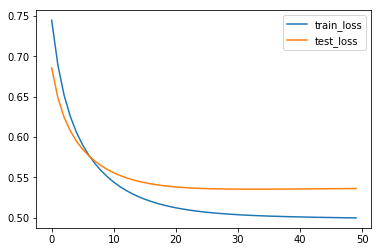

In [40]:
plt.plot(r.history['loss'],label = "train_loss")
plt.plot(r.history['val_loss'],label = "test_loss")
plt.legend()
plt.show()

In [41]:
model.save('MF_model_shf.h5')

In [33]:
#4
user = 35
mu = ratings_train.rating.mean()
movies_train = list(ratings_train[ratings_train.userId==user].movie_idx.values)
# neighbour1_movies = list(ratings_train[ratings_train.userId==sim_users[0]].movie_idx.values)
# neighbour2_movies = list(ratings_train[ratings_train.userId==sim_users[1]].movie_idx.values)
all_movies = range(200)
# unrated_movies = [i for i in all_movies if i not in movies_train if i in movies_user15_watched]
# unrated_movies = [i for i in all_movies if i not in movies_train if any([i in neighbour1_movies, i in neighbour2_movies])]
unrated_movies = [i for i in all_movies if i not in movies_train]
predictions = mu + model.predict(
    x = [np.ones(len(unrated_movies))*user,np.array(unrated_movies)]
    )
data = {'Movie' : unrated_movies,
        'Prediction':[ratings for [ratings] in predictions]
        }
my_movies = pd.DataFrame(data)
my_movies = my_movies.sort_values(by = 'Prediction',ascending = False)[0:10]
my_movies

,Movie,Prediction
14,51,3.761476
51,135,3.642534
55,143,3.622947
77,180,3.605784
26,89,3.550562
21,65,3.511626
88,194,3.501654
86,190,3.492537
16,56,3.451722
89,195,3.434139


In [85]:
#Before and after similar user rated a film
predictions = mu + new_model.predict(
    x = [[35],[165]]
    )

predictions2 = mu + model.predict(
    x = [[35],[165]]
    )
(predictions,predictions2)

(array([[3.173673]], dtype=float32), array([[3.3698921]], dtype=float32))

In [53]:
# #Which movies can apply for User User collaborative filtering
# movies_train = list(ratings_train[ratings_train.userId==35].movie_idx.values)
# movies_train2 = list(ratings_train[ratings_train.userId==15].movie_idx.values)
# all_movies = range(200)
# unrated_movies = [i for i in all_movies if all([i not in movies_train,i not in movies_train2])]
# unrated_movies

In [ ]:
#Findings so far dtd 19 Sep 19
#1. For User 35, only user 15(sim:0.39) seems to have any collaborative effect. The next most similar user, user 33(sim:0.28) has
#has much lesser effect
#2. An item user 15 liked (Movie 165:5 stars) made it to second spot on user 35's recommendations. 
#The same item when liked by user 33(5 stars) did not make it as its prediction for user 35 only rose from 3.26 to 3.4

#Schema changes dtd 20 Sep 19
#1.Users table will have one additional column:N_ratings
#2.There will be a new table - New_Interactions
#3.All new users' interactions go into this table. Once they have 20 interactions, all their interactions get auto migrated into Interactions table

#Findings dtd 22 Sep 19
#The ranking of a recommendation to a user depends on:
#1. The similarity with the user who watched that film
#2. The match between the target user and the target item

In [8]:
df = pd.read_csv('edited_ratings_subset_100x500.csv')
df = pd.DataFrame(df)
df = shuffle(df)

In [9]:
N = df.userId.max()+1
M = df.movie_idx.max()+1
cutoff = int(0.8*len(df))
ratings_train = df.iloc[:cutoff]
ratings_test = df.iloc[cutoff:]

In [10]:
K = 10
#K = 3
mu = ratings_train.rating.mean()
epochs=50
reg = 0.001
#reg = 0.0005
#reg = 0.15
u = Input(shape = (1,))
m = Input(shape = (1,))
u_embedding = Embedding(N,K,embeddings_regularizer = l2(reg))(u)
m_embedding = Embedding(M,K,embeddings_regularizer = l2(reg))(m)

u_bias = Embedding(N,1,embeddings_regularizer = l2(reg))(u)
m_bias = Embedding(M,1,embeddings_regularizer = l2(reg))(m)
x = Dot(axes = 2)([u_embedding,m_embedding])

x = Add()([x, u_bias, m_bias])
x = Flatten()(x)

model = Model(inputs = [u, m], output = x)

/Users/Anant/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("fl...)`


In [11]:
model.compile(
loss = 'mse',
#optimizer = SGD(lr = 0.009, momentum = 0.9),
optimizer = 'adam',
#optimizer = SGD(lr = 0.009),
metrics = ['mse']
)

In [12]:
r = model.fit(
    x = [ratings_train.userId.values, ratings_train.movie_idx.values],
    y = ratings_train.rating.values - mu,
    epochs = epochs,
    batch_size = 64,
    validation_data = (
        [ratings_test.userId.values, ratings_test.movie_idx.values],
        ratings_test.rating.values - mu
    ),
    shuffle = False
)

Train on 16603 samples, validate on 4151 samples
Epoch 1/50
16603/16603 [==============================] - 1s 54us/step - loss: 0.8684 - mean_squared_error: 0.8665 - val_loss: 0.8531 - val_mean_squared_error: 0.8513
Epoch 2/50
16603/16603 [==============================] - 1s 47us/step - loss: 0.8076 - mean_squared_error: 0.8042 - val_loss: 0.8060 - val_mean_squared_error: 0.8001
Epoch 3/50
16603/16603 [==============================] - 1s 39us/step - loss: 0.7640 - mean_squared_error: 0.7531 - val_loss: 0.7711 - val_mean_squared_error: 0.7542
Epoch 4/50
16603/16603 [==============================] - 1s 36us/step - loss: 0.7314 - mean_squared_error: 0.7074 - val_loss: 0.7476 - val_mean_squared_error: 0.7167
Epoch 5/50
16603/16603 [==============================] - 1s 39us/step - loss: 0.7095 - mean_squared_error: 0.6724 - val_loss: 0.7338 - val_mean_squared_error: 0.6914
Epoch 6/50
16603/16603 [==============================] - 1s 42us/step - loss: 0.6959 - mean_squared_error: 0.6492 -

16603/16603 [==============================] - 1s 46us/step - loss: 0.6624 - mean_squared_error: 0.5950 - val_loss: 0.7025 - val_mean_squared_error: 0.6352
Epoch 50/50
16603/16603 [==============================] - 1s 50us/step - loss: 0.6624 - mean_squared_error: 0.5950 - val_loss: 0.7025 - val_mean_squared_error: 0.6352


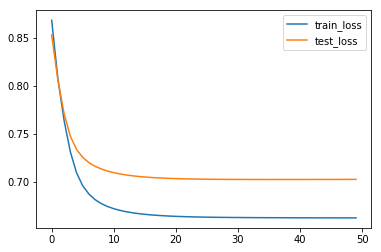

In [13]:
plt.plot(r.history['loss'],label = "train_loss")
plt.plot(r.history['val_loss'],label = "test_loss")
plt.legend()
plt.show()

In [14]:
model.save('MF_shf.h5')